## GENERATE CALIBRATION 
### Sunanda Sharma 
### Last update: 2025-01-27 

The DIY Raman used in this project is the Open Raman system (https://www.open-raman.org/), Starter 
Version. This is a low cost 532 nm spontaneous Raman system that can be used in two configurations, 
solid and liquid. This notebook is relevant for both configurations. The motivation is to provide a 
way to characterize the behavior and capabilities of the system, provide information for 
troubleshooting or possible improvements, and compare the results of this system to others, both in 
house and in literature/databases. The notebook repeats a series of steps with different samples: 
import data, plot, find peaks, fit peaks with gaussians, compare with published reference data, 
create linear equation for adjustment, and measure fit. 

### The aims of this notebook are: 
* To provide a conversion from the pixel to wavelength (nm) to wavenumber (cm-1) space
    * Wavenumber (cm-1) is typically used for Raman spectroscopy and is a relative value based on 
    the excitation wavelength. The excitation line is usually provided in nanometers (e.g. 532 nm)
* To calibrate the system to an organic standard material to improve the expected error of the 
system (i.e. the +/- cm-1) and reflect acquisition conditions
* To generate experimental values for key metrics: the positional error, the full width half maximum
 (peak width), and signal to noise ratio (SNR) for peaks in the reference material

## 1. Set up

This step imports packages, libraries, and modules necessary to run this notebook and creates the necessary folders for the notebook outputs. 

In [4]:
# Imports

import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import arcadia_pycolor as apc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit.models import GaussianModel, Model
from pybaselines.whittaker import airpls
from scipy.signal import find_peaks, medfilt
from sklearn.metrics import r2_score

# Set up

apc.mpl.setup()
%matplotlib widget

# Check or create folders

folders_to_check = [
    "../data",
    "../data/processed",
    "../data/raw/",
    "../data/processed/calibration/",
    "../data/processed/performance/",
    "../data/processed/processed_data/",
]
for folder in folders_to_check:
    if not os.path.exists(folder):
        print(f"Folder {folder} does not exist. Creating...")
        os.makedirs(folder)

print("Folders checked and created.")

Folders checked and created.


## 2. Create the dataframes for reference material peaks

This step creates dataframes for the reference materials used for calibration, neon and 
acetonitrile. Each dataframe has peaks that have been verified in published literature. 

Neon: NIST (https://physics.nist.gov/PhysRefData/Handbook/Tables/neontable2.htm)

Acetonitrile: NIST (https://webbook.nist.gov/cgi/cbook.cgi?ID=C75058&Mask=800)

In [5]:
df_ref_neon_peaks = [585.249, 588.189, 594.483, 607.434, 609.616, 614.306, 616.359, 621.728,
                     626.649,630.479, 633.443, 638.299, 640.225, 650.653, 653.288]
df_ref_neon_peaks = pd.DataFrame(df_ref_neon_peaks, columns=["nm"])
df_ref_acetonitrile_peaks = [918, 1376, 2249, 2942, 2999]
df_ref_acetonitrile_peaks = pd.DataFrame(df_ref_acetonitrile_peaks, columns=["cm-1"])

## 3. Load the acquired data on the reference materials

This step loads the acquired data for the reference materials. The file naming format includes key 
metadata:
"YYYY-MM-DD_samplename_blanked?_baselined?_filtered?_exposure(ms)_gain(dB)_#averagedspectra.csv". 
The metadata relates to the acquisition parameters and we typically do not blank before 
acquisition and 0 dB. 
In this step, we can also filter the data if median filtering wasn't already applied during
acquisition, and apply baseline correction to remove background fluorescence or stray light. This
improves peak detection in the next step. 

In [6]:
# Function to parse the file name to get the metadata

def parse_file_name(file_path):
    file = os.path.basename(file_path)
    file_name = file.split(".")[0]
    file_name_parts = file_name.split("_")
    file_date = file_name_parts[0]
    file_sample = file_name_parts[1]
    file_blank = file_name_parts[2]
    file_baseline = file_name_parts[3]
    file_filtered = file_name_parts[4]
    file_config = file_name_parts[5]
    file_exposure = file_name_parts[6]
    file_gain = file_name_parts[7]
    file_averages = file_name_parts[8]
    return [
        file_date, file_config, file_sample, file_blank, file_baseline, file_filtered,
        file_exposure, file_gain, file_averages, file_name]

Text(0.5, 1.0, '2024-08-27 solid neon raw and baseline corrected')

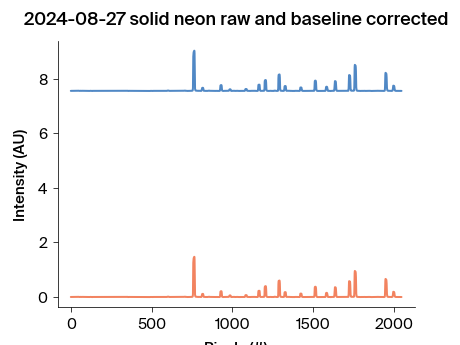

In [7]:
# Pop up a dialog to select the neon file for the day/config of interest

Tk().withdraw()

neon_acq_file_path = askopenfilename(
    title="Select file for neon calibration",
)
df_acq_neon = pd.read_csv(neon_acq_file_path, names=["Pixels #", "Intensity (a.u.)"], skiprows=1)

# Create subfolders in processed/performance, processed/processed_data, and processed/calibration
# with the date

date = parse_file_name(neon_acq_file_path)[0]
os.makedirs(f"../data/processed/performance/{date}", exist_ok=True)
os.makedirs(f"../data/processed/processed_data/{date}", exist_ok=True)
os.makedirs(f"../data/processed/calibration/{date}", exist_ok=True)

# Check if median filter is needed

if parse_file_name(neon_acq_file_path)[4] == "n":
    df_acq_neon["Intensity (a.u.)"] = medfilt(df_acq_neon["Intensity (a.u.)"], 3)
else:
    pass

# Apply baseline correction using airPLS

df_acq_neon_baseline = airpls(df_acq_neon["Intensity (a.u.)"], lam=1000000,
                                                   diff_order=1, max_iter=50, tol=0.001)[0]
df_acq_neon["Baselined Intensity (a.u.)"] = df_acq_neon["Intensity (a.u.)"] - df_acq_neon_baseline

# Plot the neon spectrum before and after baselining

plt.figure()
plt.plot(df_acq_neon["Pixels #"], df_acq_neon["Intensity (a.u.)"])
plt.plot(df_acq_neon["Pixels #"], df_acq_neon["Baselined Intensity (a.u.)"])
plt.xlabel("Pixels (#)")
plt.ylabel("Intensity (AU)")
plt.title(parse_file_name(neon_acq_file_path)[0]+ " " +parse_file_name(neon_acq_file_path)[1]+" "+
           parse_file_name(neon_acq_file_path)[2]+" raw and baseline corrected")

Text(0.5, 1.0, '2024-08-27 solid acetonitrile raw and baseline corrected')

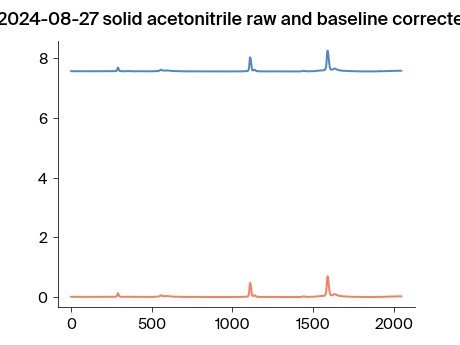

In [9]:
# Pop up a dialog to select the acetonitrile file for the day/config of interest

acetonitrile_acq_file_path = askopenfilename(
    title="Select file for acetonitrile calibration",
)
df_acq_acetonitrile = pd.read_csv(acetonitrile_acq_file_path,
                                  names=["Pixels #", "Intensity (a.u.)"], skiprows=1)

# Check if median filter is needed

if parse_file_name(acetonitrile_acq_file_path)[4] == "n":
    df_acq_acetonitrile["Intensity (a.u.)"] = medfilt(df_acq_acetonitrile["Intensity (a.u.)"], 3)
else:
    pass

# Apply baseline correction using airPLS

df_acq_acetonitrile_baseline = airpls(df_acq_acetonitrile["Intensity (a.u.)"], lam=1000000,
                                        diff_order=1, max_iter=50, tol=0.001)[0]
df_acq_acetonitrile["Baselined Intensity (a.u.)"] = (
    df_acq_acetonitrile["Intensity (a.u.)"] - df_acq_acetonitrile_baseline
)

# Plot the acetonitrile spectrum

plt.figure()
plt.plot(df_acq_acetonitrile["Pixels #"], df_acq_acetonitrile["Intensity (a.u.)"])
plt.plot(df_acq_acetonitrile["Pixels #"], df_acq_acetonitrile["Baselined Intensity (a.u.)"])
plt.title(
    parse_file_name(acetonitrile_acq_file_path)[0]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[1]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[2]
+" raw and baseline corrected")

## 4. Find and fit peaks in neon data

To use the neon for calibration, we first need to find and fit the peaks. The steps for this
are: estimate peaks using scipy find peaks, fit those peak curves with lmfit, report fitted peak 
centers, and create a linear model. Using scipy find peaks alone won't be sufficient, since it finds
a local maximum rather than the true peak center of the curve. lmfit has a lot of models that can be 
used to fit peaks, but we can use gaussians to fit the curve sufficiently well. Each peak in the 
spectrum is fit individually with lmfit, as the spectrum is broken up into smaller regions using the 
estimated peak positions from scipy find peaks. The width of these regions is set manually and can
affect the peak fitting. You can check how well the gaussian is fitting and adjust as needed.

Note: the gaussian won't fit the exact profile of the neon peaks, because this is direct light on 
the detector that will fill the slit, leading to a "flat top gaussian" shape. Still, we should be
able to sufficiently estimate peak centers. 

Text(0.5, 1.0, '2024-08-27 solid neon with estimated peaks')

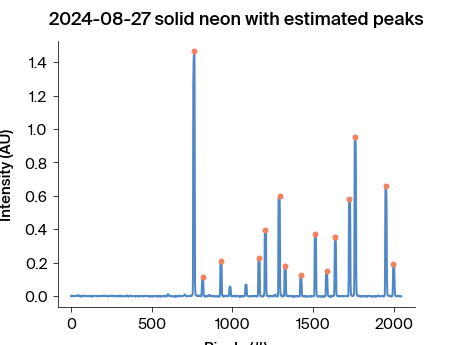

In [10]:
# Find the peaks in the neon spectrum

num_neon_peaks = 15
prominence = 0

while True:
    neon_peaks, _ = find_peaks(df_acq_neon["Baselined Intensity (a.u.)"], prominence=prominence)
    if len(neon_peaks) == num_neon_peaks:
        break
    prominence += 0.05

neon_peaks_x = df_acq_neon["Pixels #"][neon_peaks]
neon_peaks_y = df_acq_neon["Baselined Intensity (a.u.)"][neon_peaks]

# Plot the baseline corrected neon spectrum with the estimated peaks

plt.figure()
plt.plot(df_acq_neon["Pixels #"], df_acq_neon["Baselined Intensity (a.u.)"])
plt.plot(neon_peaks_x, neon_peaks_y, "o")
plt.xlabel("Pixels (#)")
plt.ylabel("Intensity (AU)")
plt.title(
    parse_file_name(neon_acq_file_path)[0]+ " " +
    parse_file_name(neon_acq_file_path)[1]+ " " +
    parse_file_name(neon_acq_file_path)[2]
+" with estimated peaks")

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 24
    # variables        = 3
    chi-square         = 0.89708663
    reduced chi-square = 0.04271841
    Akaike info crit   = -72.8797603
    Bayesian info crit = -69.3455988
    R-squared          = 0.91156144
[[Variables]]
    amplitude:  15.7018231 +/- 0.92233955 (5.87%) (init = 21.96568)
    center:     762.200228 +/- 0.25349180 (0.03%) (init = 762)
    sigma:      3.73939534 +/- 0.25391819 (6.79%) (init = 5)
    fwhm:       8.80560293 +/- 0.59793163 (6.79%) == '2.3548200*sigma'
    height:     1.67516961 +/- 0.09837300 (5.87%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5782
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 24
    # variables        = 3
    chi-square         = 0.00

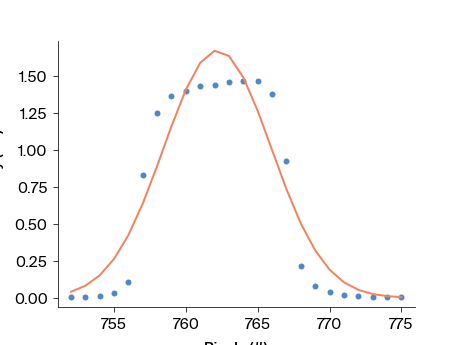

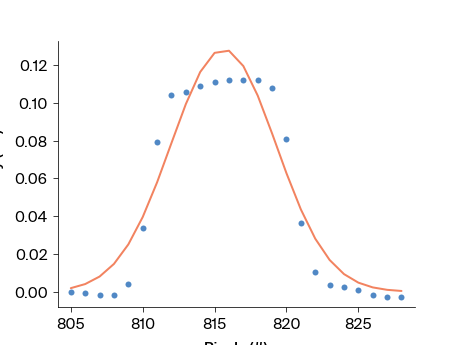

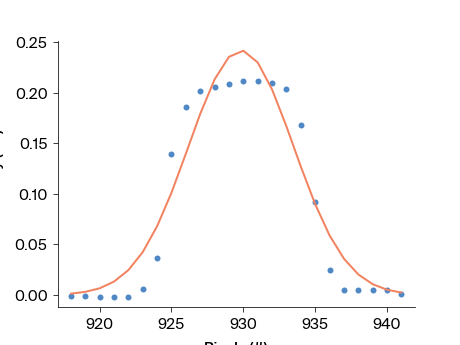

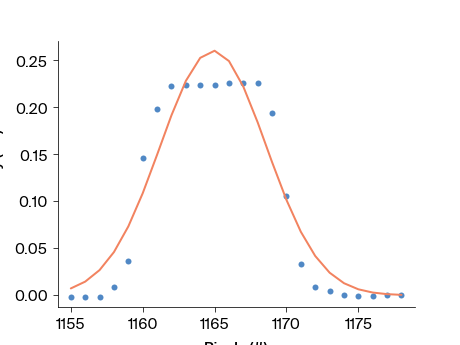

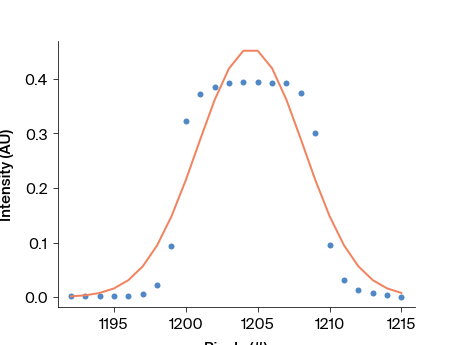

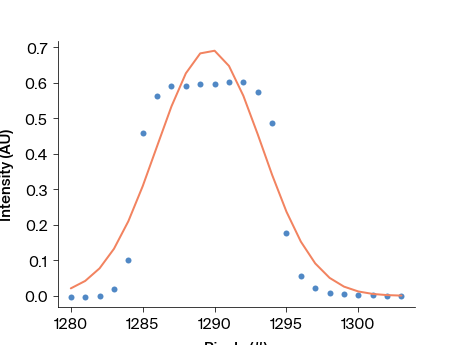

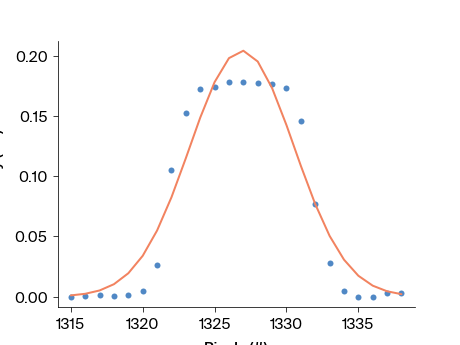

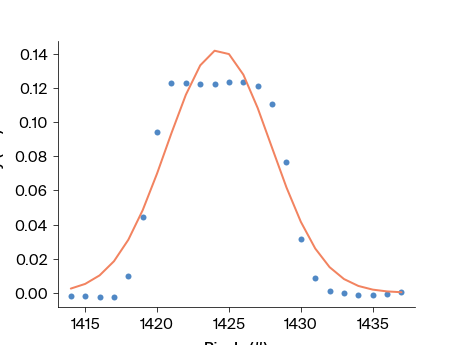

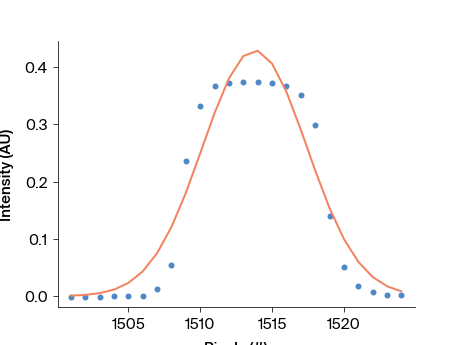

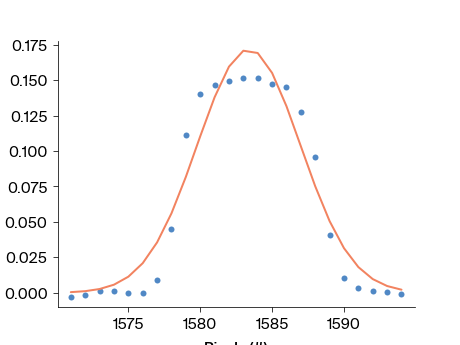

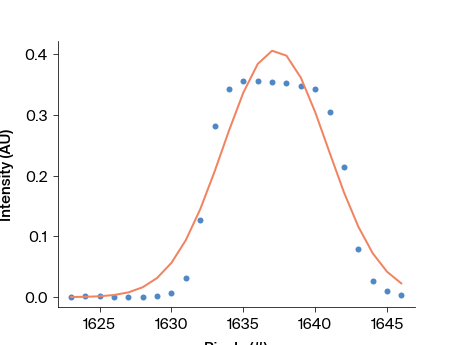

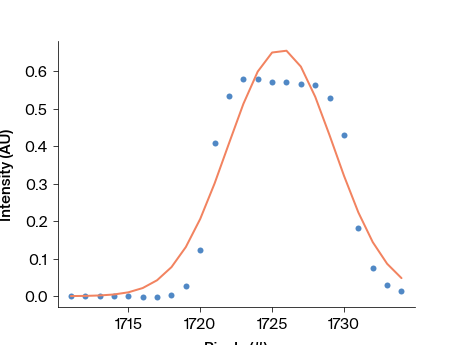

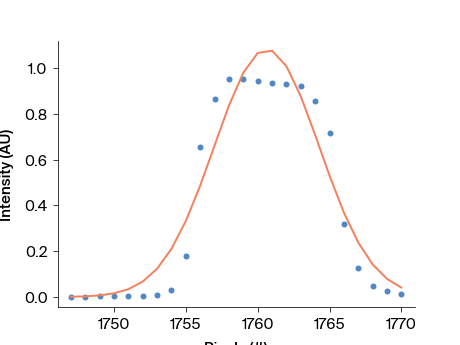

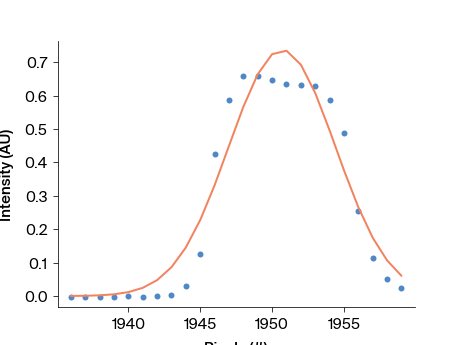

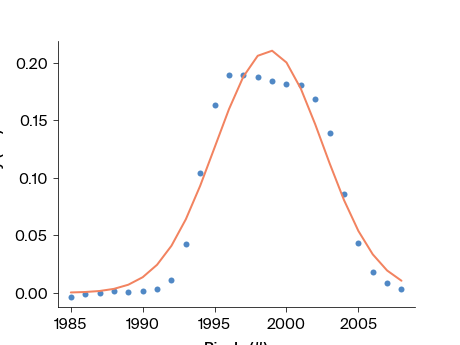

In [11]:
# Function to fit a Gaussian to a peak region

def fit_gaussian(x, y):
    model = GaussianModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    return result

# Isolate each peak region

neon_width = 24
neon_peak_regions = []

for neon_peak in neon_peaks:
    start = max(0, neon_peak - neon_width // 2)
    end = min(len(df_acq_neon["Baselined Intensity (a.u.)"]), neon_peak + neon_width // 2)
    neon_peak_regions.append((start, end))

# Create lists to store the peak fitting results

neon_centers = []
neon_intensities = []
neon_fwhm = []

# Fit a Gaussian to each peak region

for start, end in neon_peak_regions:
    x_region = df_acq_neon["Pixels #"][start:end]
    y_region = df_acq_neon["Baselined Intensity (a.u.)"][start:end]
    result = fit_gaussian(x_region.values, y_region.values)
    center = result.params["center"].value
    neon_centers.append(center)
    neon_intensities.append(df_acq_neon["Baselined Intensity (a.u.)"]
                            [np.argmin(np.abs(df_acq_neon["Pixels #"] - center))])
    neon_fwhm.append(result.params["fwhm"].value)

    # Plot results for each peak

    plt.figure()
    plt.plot(x_region, y_region, "o")
    plt.plot(x_region, result.best_fit)
    plt.xlabel("Pixels (#)")
    plt.ylabel("Intensity (AU)")
    print(result.fit_report())

Text(0.5, 1.0, '2024-08-27 solid neon with fitted peaks')

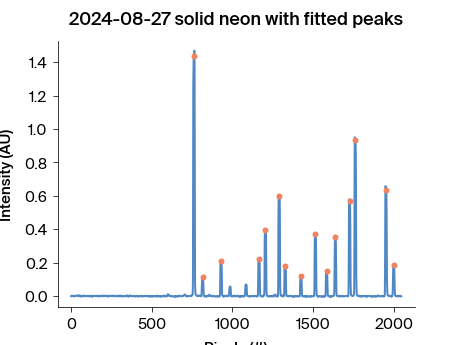

In [12]:
# Plot the fitted peaks with the baseline corrected neon spectrum

plt.figure()
plt.plot(df_acq_neon["Pixels #"], df_acq_neon["Baselined Intensity (a.u.)"])
plt.plot(neon_centers,neon_intensities, "o")
plt.xlabel("Pixels (#)")
plt.ylabel("Intensity (AU)")
plt.title(
    parse_file_name(neon_acq_file_path)[0]+ " " +
    parse_file_name(neon_acq_file_path)[1]+ " " +
    parse_file_name(neon_acq_file_path)[2]
+" with fitted peaks")

## 5. Create pixels to nanometers conversion equation using neon data

We have the reference values for neon from literature, reported in wavelength (nanometers), and
can use this to convert the peaks in the neon spectrum from pixels to nanometers. We will create
a conversion equation that can be applied to all subsequent data. Atomic emission sources, like
neon, are commonly used for this type of calibration because they provide absolute wavelength
references, have sharp and well defined peaks, and are not greatly affected by temperature and 
pressure or other environmental factors. 

Text(0.5, 1.0, 'R^2: 0.9999992874778898')

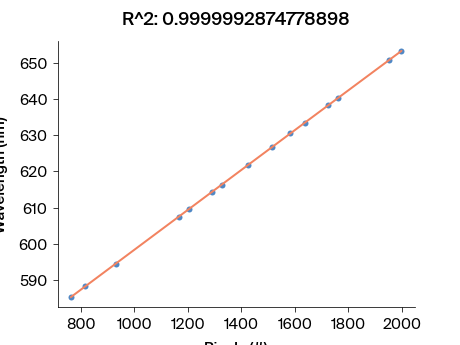

In [13]:
# Create a linear function to convert pixel values to nanometers

def linear_model(x, slope, intercept):
    return slope * x + intercept

# Fit the linear model to the neon peaks

neon_observed_centers = np.array(neon_centers)
neon_expected_centers = df_ref_neon_peaks["nm"].values

model = Model(linear_model)
params = model.make_params(slope=1, intercept=0)
result = model.fit(neon_expected_centers, params, x=neon_observed_centers)
neon_slope = result.params["slope"].value
neon_intercept = result.params["intercept"].value

neon_y_predicted = linear_model(neon_observed_centers, neon_slope, neon_intercept)

# Calculate the R^2 value using sklearn r2_score

neon_r2 = r2_score(neon_expected_centers, neon_y_predicted)

# Plot the fitted linear function and the data points

plt.figure()
plt.plot(neon_observed_centers, neon_y_predicted, "o")
plt.plot(neon_observed_centers, neon_expected_centers)
plt.xlabel("Pixels (#)")
plt.ylabel("Wavelength (nm)")
plt.title(f"R^2: {neon_r2}")

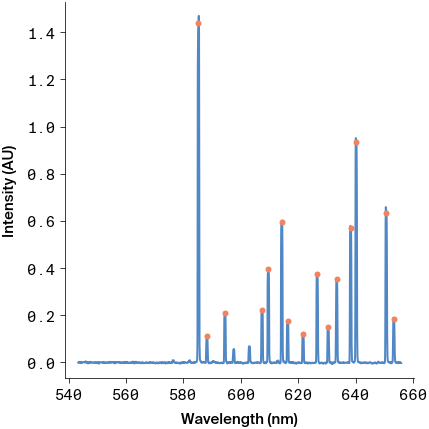

In [19]:
# Create function to convert pixel values to wavenumbers

def pixel_to_wavenumber(pixel, slope, intercept):
    pixel = np.array(pixel)
    return slope * pixel + intercept

df_acq_neon_nm = pixel_to_wavenumber(df_acq_neon["Pixels #"].values, neon_slope, neon_intercept)

# Convert the fitted peak centers and widths to nm space

neon_centers_nm = pixel_to_wavenumber(neon_centers, neon_slope, neon_intercept)
neon_fwhm_nm = np.array(neon_fwhm) * neon_slope

# Plot the fitted peaks with the baseline corrected neon spectrum in nm space

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(figsize=(apc.mpl.get_figure_dimensions("full_square")),layout="constrained")
    plt.plot(df_acq_neon_nm, df_acq_neon["Baselined Intensity (a.u.)"])
    plt.plot(neon_centers_nm, neon_intensities, "o")
    apc.mpl.style_plot(monospaced_axes="both")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity (AU)")

# Save the plot to the calibration folder with the date
plt.savefig((f"../data/processed/calibration/{date}")+"/"
            +parse_file_name(neon_acq_file_path)[9]+".svg",
            dpi=72,bbox_inches="tight", pad_inches=20 / 72,transparent=True)

Mean error: -1.5158245029548804e-14
Standard deviation of error: 0.017912262854686608
Maximum difference: 0.038812802606912555
Minimum difference: -0.019322827153359867


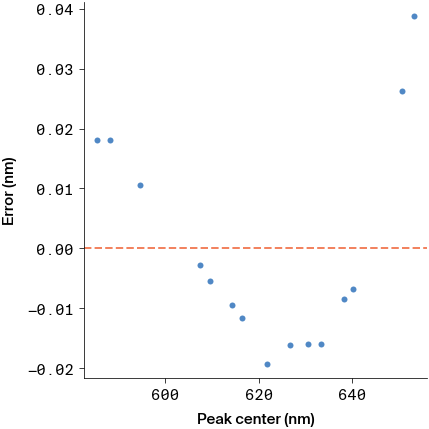

In [20]:
# Create dataframe with the fitted peaks center, intensities, and fwhm

df_acq_neon_peaks = pd.DataFrame(
    {
        "Center (nm)": neon_centers_nm,
        "Intensity (AU)": neon_intensities,
        "FWHM (nm)": neon_fwhm_nm,
    },
)

# Check df_acq_neon_peaks and df_ref_neon_peaks have the same length

if len(df_acq_neon_peaks) != len(df_ref_neon_peaks):
    raise ValueError("The number of peaks in the reference and acquired dataframes do not match.")

# Calculate the error between the acquired and reference peaks

df_acq_neon_peaks["Error (nm)"] = df_acq_neon_peaks["Center (nm)"] - df_ref_neon_peaks["nm"]

# Calculate summary statistics

neon_mean_error = df_acq_neon_peaks["Error (nm)"].mean()
neon_std_error = df_acq_neon_peaks["Error (nm)"].std()
neon_max_diff = df_acq_neon_peaks["Error (nm)"].max()
neon_min_diff = df_acq_neon_peaks["Error (nm)"].min()

print(f"Mean error: {neon_mean_error}")
print(f"Standard deviation of error: {neon_std_error}")
print(f"Maximum difference: {neon_max_diff}")
print(f"Minimum difference: {neon_min_diff}")

# Plot the error between the acquired and reference peaks

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(figsize=(apc.mpl.get_figure_dimensions("full_square")),layout="constrained")
    plt.plot(df_acq_neon_peaks["Center (nm)"], df_acq_neon_peaks["Error (nm)"], "o")
    plt.axhline(0, color=apc.palettes.primary.colors[1], linestyle="--")
    apc.mpl.style_plot(monospaced_axes="both")
    plt.xlabel("Peak center (nm)")
    plt.ylabel("Error (nm)")

# Save the plot to the performance folder with the date
plt.savefig((f"../data/processed/performance/{date}")+"/"
            +parse_file_name(neon_acq_file_path)[9]+"_neonerror.svg",
            dpi=72,bbox_inches="tight", pad_inches=20 / 72,transparent=True)

If you're satisfied with the above results, you can save the summary statistics, the coefficients of the linear fit, and the neon spectrum in nm space into csvs that goes in the output folder to apply to the data you collected that day. If you're not satisfied, you can repeat the above, tweaking parameters until you get to a decent result.  

In [30]:
# Create dataframe including summary statistics and save it to the performance folder with the date

df_acq_neon_summary = pd.DataFrame(
    {
        "Mean error (nm)": [neon_mean_error],
        "Standard deviation of error (nm)": [neon_std_error],
        "Maximum difference (nm)": [neon_max_diff],
        "Minimum difference (nm)": [neon_min_diff],
    },
)

df_acq_neon_summary.to_csv((f"../data/processed/performance/{date}")+"/"
                           +parse_file_name(neon_acq_file_path)[9]+"_summary.csv")

# Save the acquired neon peaks to the calibration data folder with the date

df_acq_neon_peaks.to_csv((f"../data/processed/calibration/{date}")+"/"
                         +parse_file_name(neon_acq_file_path)[9]+"_neonpeaks.csv")

# Create a dataframe with the neon linear coefficients and save it to the calibration folder with
# the date

df_acq_neon_coefficients = pd.DataFrame(
    {
        "Slope": [neon_slope],
        "Intercept": [neon_intercept],
    },
)

df_acq_neon_coefficients.to_csv((f"../data/processed/calibration/{date}")+"/"
                                +parse_file_name(neon_acq_file_path)[9]+"_neoncoefficients.csv")

# Add the nm values to the neon acq dataframe and save as csv in the processed data folder with date

df_acq_neon["Wavelength (nm)"] = df_acq_neon_nm
df_acq_neon.to_csv((f"../data/processed/processed_data/{date}")+"/"
                   +parse_file_name(neon_acq_file_path)[9]+".csv")

## 6. Find and fit peaks in acetonitrile data

The neon spectrum allows us to calibrate the sample to detector path and allows for the conversion of pixel to wavelength (nm) space, but does not use the laser or actual Raman scatter. To further calibrate, we should also run a standard sample like acetonitrile (in a quartz cuvette) to evaluate fit error in the wavenumber (cm-1) space and assess error in the lower wavelength region relevant for many fundamental organic peaks. The acetonitrile sample has well known peaks, can help correct for systematic errors in the Raman shift calculation equation, helps us find potential wavelength-dependent responses in our system (e.g. if we are attenuating Raman signal in some way), can correct for small variations based on environmental conditions and laser strength, validates the neon calibration, and can be used to test the laser strength over time. 

According to the tests for Open Raman powder samples, the peak positions can be off up to 50cm-1, so an additional check is good to apply (https://www.thepulsar.be/article/solid-powder-raman-spectroscopy/). 

The reference data is from the NIST webbook (https://webbook.nist.gov/cgi/cbook.cgi?ID=C75058&Mask=800).

In [22]:
# Apply the linear model to the acetonitrile spectrum to convert from pixels to nm

df_acq_acetonitrile_nm = pixel_to_wavenumber(df_acq_acetonitrile["Pixels #"].values, neon_slope,
                                                neon_intercept)

# Create equation to convert wavelength to Raman shift (cm-1, wavenumbers)

def wavelength2shift(wavelength, excitation=532):
    shift = ((1./excitation)-(1./wavelength))*(10**7)
    return shift

# Apply the function to the acetonitrile spectrum

df_acq_acetonitrile["Wavelength (nm)"] = df_acq_acetonitrile_nm
df_acq_acetonitrile["Raman shift (cm-1)"] = wavelength2shift(df_acq_acetonitrile["Wavelength (nm)"])

Text(0.5, 1.0, '2024-08-27 solid acetonitrile with estimated peaks')

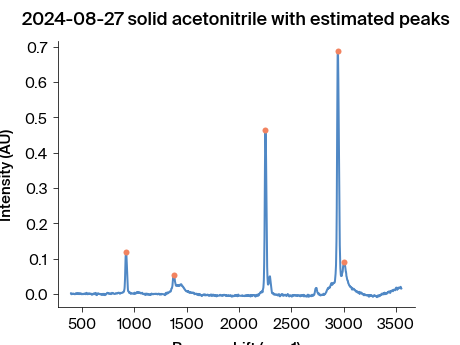

In [24]:
# Find the peaks in the acetonitrile spectrum

num_acetonitrile_peaks = 5
prominence = 0

while True:
    acetonitrile_peaks, _ = find_peaks(df_acq_acetonitrile["Baselined Intensity (a.u.)"],
                                       prominence=prominence, width=5)
    if len(acetonitrile_peaks) == num_acetonitrile_peaks:
        break
    prominence += 0.00005

acetonitrile_peaks_x = df_acq_acetonitrile["Raman shift (cm-1)"][acetonitrile_peaks]
acetonitrile_peaks_y = df_acq_acetonitrile["Baselined Intensity (a.u.)"][acetonitrile_peaks]

# Plot the baseline corrected neon spectrum with the estimated peaks

plt.figure()
plt.plot(df_acq_acetonitrile["Raman shift (cm-1)"],
         df_acq_acetonitrile["Baselined Intensity (a.u.)"])
plt.plot(acetonitrile_peaks_x, acetonitrile_peaks_y, "o")
plt.xlabel("Raman shift (cm-1)")
plt.ylabel("Intensity (AU)")
plt.title(
    parse_file_name(acetonitrile_acq_file_path)[0]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[1]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[2]
+" with estimated peaks")

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 22
    # variables        = 3
    chi-square         = 2.3604e-04
    reduced chi-square = 1.2423e-05
    Akaike info crit   = -245.736174
    Bayesian info crit = -242.463047
    R-squared          = 0.99333120
[[Variables]]
    amplitude:  2.39334041 +/- 0.03045698 (1.27%) (init = 2.925461)
    center:     920.258310 +/- 0.11428610 (0.01%) (init = 920.3206)
    sigma:      7.82690834 +/- 0.11642353 (1.49%) (init = 8.794377)
    fwhm:       18.4309603 +/- 0.27415646 (1.49%) == '2.3548200*sigma'
    height:     0.12199002 +/- 0.00154539 (1.27%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5883
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 22
    # variables        = 3
    chi-square   

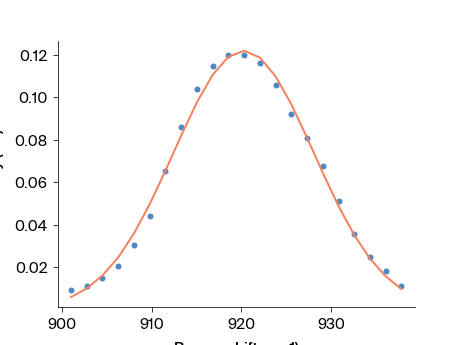

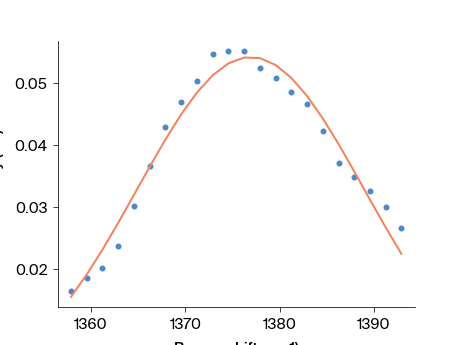

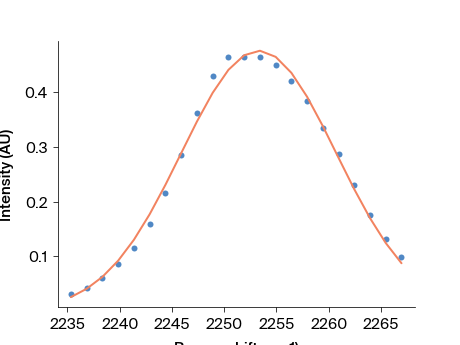

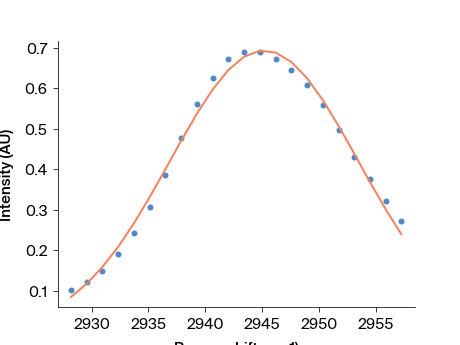

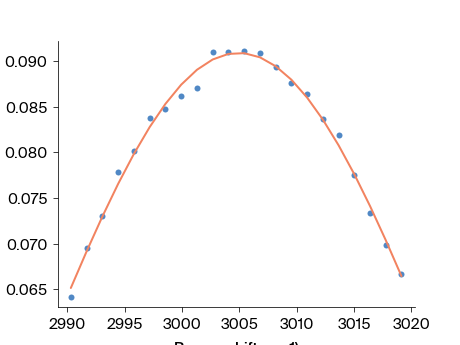

In [28]:
# Isolate each peak region

acetonitrile_width = 22
acetonitrile_peak_regions = []

for acetonitrile_peak in acetonitrile_peaks:
    start = max(0, acetonitrile_peak - acetonitrile_width // 2)
    end = min(len(df_acq_acetonitrile["Baselined Intensity (a.u.)"]),
              acetonitrile_peak + acetonitrile_width // 2)
    acetonitrile_peak_regions.append((start, end))

# Create lists to store the peak fitting results

acetonitrile_centers = []
acetonitrile_intensities = []
acetonitrile_fwhm = []

# Fit a Gaussian to each peak region

for start, end in acetonitrile_peak_regions:
    x_region = df_acq_acetonitrile["Raman shift (cm-1)"][start:end]
    y_region = df_acq_acetonitrile["Baselined Intensity (a.u.)"][start:end]
    result = fit_gaussian(x_region.values, y_region.values)
    center = result.params["center"].value
    acetonitrile_centers.append(center)
    acetonitrile_intensities.append(df_acq_acetonitrile["Baselined Intensity (a.u.)"]
                            [np.argmin(np.abs(df_acq_acetonitrile["Raman shift (cm-1)"] - center))])
    acetonitrile_fwhm.append(result.params["fwhm"].value)

    # Plot results for each peak

    plt.figure()
    plt.plot(x_region, y_region, "o")
    plt.plot(x_region, result.best_fit)
    plt.xlabel("Raman shift cm-1)")
    plt.ylabel("Intensity (AU)")
    print(result.fit_report())

Text(0.5, 1.0, '2024-08-27 solid acetonitrile with fitted peaks')

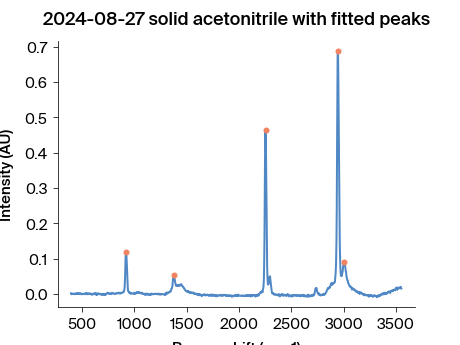

In [29]:
# Plot the fitted peaks with the baseline corrected acetonitrile spectrum

plt.figure()
plt.plot(df_acq_acetonitrile["Raman shift (cm-1)"],
         df_acq_acetonitrile["Baselined Intensity (a.u.)"])
plt.plot(acetonitrile_centers, acetonitrile_intensities, "o")
plt.xlabel("Raman shift (cm-1)")
plt.ylabel("Intensity (AU)")
plt.title(
    parse_file_name(acetonitrile_acq_file_path)[0]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[1]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[2]
+" with fitted peaks")

### 7. Generate a linear equation to adjust the Raman spectrum further

To both reduce the error as much as possible and understand error across the detector in cm-1, we can generate a secondary linear equation from the acetonitrile. This is a similar process to neon, and the processed data will be saved with '_calibrated2' at the end of the filename. We're hoping to have an error of less than 2 cm-1 in the range of primary organic peaks, which are typically between ~800-1800 cm-1. 

Text(0.5, 1.0, 'R^2: 0.9999981609483795')

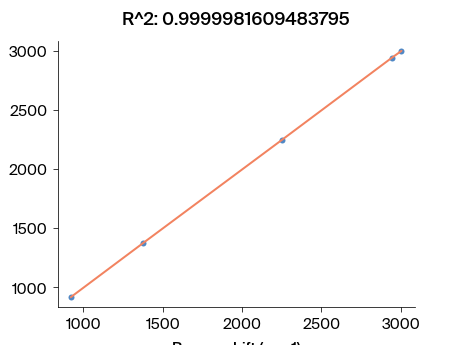

In [31]:
# Fit a linear model to the acetonitrile peaks

acetonitrile_observed_centers = np.array(acetonitrile_centers)
acetonitrile_expected_centers = df_ref_acetonitrile_peaks["cm-1"].values

model = Model(linear_model)
params = model.make_params(slope=1, intercept=0)
result = model.fit(acetonitrile_expected_centers, params, x=acetonitrile_observed_centers)
acetonitrile_slope = result.params["slope"].value
acetonitrile_intercept = result.params["intercept"].value

acetonitrile_y_predicted = linear_model(acetonitrile_observed_centers, acetonitrile_slope,
                                        acetonitrile_intercept)

# Calculate the R^2 value using sklearn r2_score

acetonitrile_r2 = r2_score(acetonitrile_expected_centers, acetonitrile_y_predicted)

# Plot the fitted linear function and the data points

plt.figure()
plt.plot(acetonitrile_observed_centers, acetonitrile_y_predicted, "o")
plt.plot(acetonitrile_observed_centers, acetonitrile_expected_centers)
plt.xlabel("Raman shift (cm-1)")
plt.ylabel("Raman shift (cm-1)")
plt.title(f"R^2: {acetonitrile_r2}")

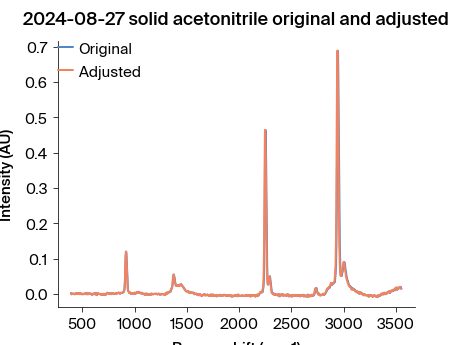

In [ ]:
# Create an equation to adjust the Raman shift to the expected values

def adjust_shift(x, slope, intercept):
    x = np.array(x)
    return slope * x + intercept

# Apply the function to the acetonitrile peaks and the acetonitrile spectrum

acetonitrile_centers_cm1 = adjust_shift(acetonitrile_centers, acetonitrile_slope,
                                        acetonitrile_intercept)

acetonitrile_fwhm_cm1 = np.array(acetonitrile_fwhm) * acetonitrile_slope

df_acq_acetonitrile["Raman shift (cm-1) adjusted"] = adjust_shift(
    df_acq_acetonitrile["Raman shift (cm-1)"], acetonitrile_slope, acetonitrile_intercept,
)

# Plot the original and the adjusted spectra; should be a very small difference when zoomed in

plt.figure()
plt.plot(df_acq_acetonitrile["Raman shift (cm-1)"],
         df_acq_acetonitrile["Baselined Intensity (a.u.)"])
plt.plot(df_acq_acetonitrile["Raman shift (cm-1) adjusted"],
        df_acq_acetonitrile["Baselined Intensity (a.u.)"])
plt.xlabel("Raman shift (cm-1)")
plt.ylabel("Intensity (AU)")
plt.title(
    parse_file_name(acetonitrile_acq_file_path)[0]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[1]+ " " +
    parse_file_name(acetonitrile_acq_file_path)[2]
+" original and adjusted")
plt.legend(["Original", "Adjusted"])

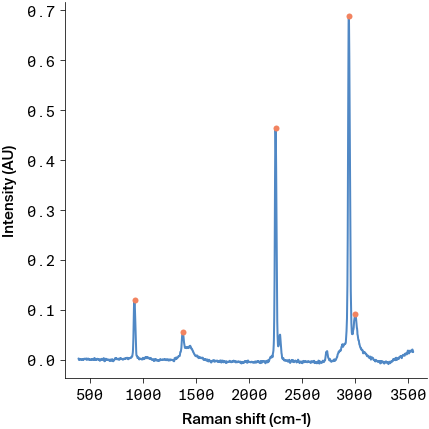

In [37]:
# Plot the fitted peaks with the baseline corrected acetonitrile spectrum and adjusted shift

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(figsize=(apc.mpl.get_figure_dimensions("full_square")),layout="constrained")
    plt.plot(df_acq_acetonitrile["Raman shift (cm-1) adjusted"],
         df_acq_acetonitrile["Baselined Intensity (a.u.)"])
    plt.plot(acetonitrile_centers_cm1, acetonitrile_intensities, "o")
    apc.mpl.style_plot(monospaced_axes="both")
    plt.xlabel("Raman shift (cm-1)")
    plt.ylabel("Intensity (AU)")

# Save the plot to the calibration folder with the date
plt.savefig((f"../data/processed/calibration/{date}")+"/"
            +parse_file_name(acetonitrile_acq_file_path)[9]+".svg",
            dpi=72,bbox_inches="tight", pad_inches=20 / 72,transparent=True)

Mean error: 3.173522600263823e-08
Standard deviation of error: 1.261373185872081
Maximum difference: 1.2194379122483952
Minimum difference: -1.4604440097405131


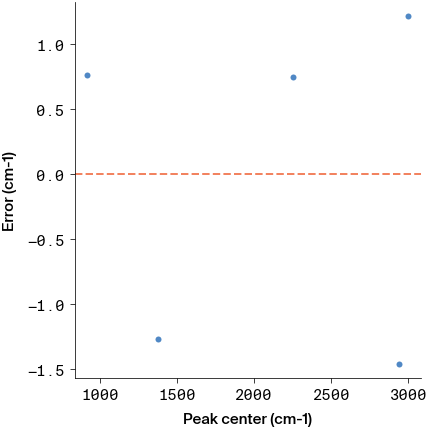

In [40]:
# Create dataframe with the acetonitrile fitted peaks center, intensities, and fwhm

df_acq_acetonitrile_peaks = pd.DataFrame(
    {
        "Center (cm-1)": acetonitrile_centers_cm1,
        "Intensity (AU)": acetonitrile_intensities,
        "FWHM (cm-1)": acetonitrile_fwhm_cm1,
    },
)

# Check df_acq_acetonitrile_peaks and df_ref_acetonitrile_peaks have the same length

if len(df_acq_acetonitrile_peaks) != len(df_ref_acetonitrile_peaks):
    raise ValueError("The number of peaks in the reference and acquired dataframes do not match.")

# Calculate the error between the acquired and reference peaks

df_acq_acetonitrile_peaks["Error (cm-1)"] = (
    df_acq_acetonitrile_peaks["Center (cm-1)"] - df_ref_acetonitrile_peaks["cm-1"]
)

# Calculate summary statistics

acetonitrile_mean_error = df_acq_acetonitrile_peaks["Error (cm-1)"].mean()
acetonitrile_std_error = df_acq_acetonitrile_peaks["Error (cm-1)"].std()
acetonitrile_max_diff = df_acq_acetonitrile_peaks["Error (cm-1)"].max()
acetonitrile_min_diff = df_acq_acetonitrile_peaks["Error (cm-1)"].min()

print(f"Mean error: {acetonitrile_mean_error}")
print(f"Standard deviation of error: {acetonitrile_std_error}")
print(f"Maximum difference: {acetonitrile_max_diff}")
print(f"Minimum difference: {acetonitrile_min_diff}")

# Plot the error between the acquired and reference peaks

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(figsize=(apc.mpl.get_figure_dimensions("full_square")),layout="constrained")
    plt.plot(df_acq_acetonitrile_peaks["Center (cm-1)"], df_acq_acetonitrile_peaks["Error (cm-1)"],
            "o")
    plt.axhline(0, color=apc.palettes.primary.colors[1], linestyle="--")
    apc.mpl.style_plot(monospaced_axes="both")
    plt.xlabel("Peak center (cm-1)")
    plt.ylabel("Error (cm-1)")

# Save the plot to the performance folder with the date

plt.savefig((f"../data/processed/performance/{date}")+"/"
            +parse_file_name(acetonitrile_acq_file_path)[9]+"_acetonitrileerror.svg",
            dpi=72,bbox_inches="tight", pad_inches=20 / 72,transparent=True)

If you're satisfied with the above results, you can save the summary statistics, the coefficients of the linear fit, and the acetonitrile spectrum with adjusted Raman shift into csvs that goes in the output folder to apply to the data you collected that day. If you're not satisfied, you can repeat the above, tweaking parameters until you get to a decent result.  

In [44]:
# Create dataframe including summary statistics and save it to the performance folder with the date

df_acq_acetonitrile_summary = pd.DataFrame(
    {
        "Mean error (nm)": [acetonitrile_mean_error],
        "Standard deviation of error (nm)": [acetonitrile_std_error],
        "Maximum difference (nm)": [acetonitrile_max_diff],
        "Minimum difference (nm)": [acetonitrile_min_diff],
    },
)

df_acq_acetonitrile_summary.to_csv((f"../data/processed/performance/{date}")+"/"
                           +parse_file_name(acetonitrile_acq_file_path)[9]+"_summary.csv")

# Create a dataframe with the acetonitrile linear coefficients and save it to the calibration folder
# with the date

df_acq_acetonitrile_coefficients = pd.DataFrame(
    {
        "Slope": [acetonitrile_slope],
        "Intercept": [acetonitrile_intercept],
    },
)

df_acq_acetonitrile_coefficients.to_csv((f"../data/processed/calibration/{date}")+"/"
                                +parse_file_name(acetonitrile_acq_file_path)[9]
                                +"_acetonitrilecoefficients.csv")

# Add the adjusted values to the acetonitrile acq dataframe,
# save as csv in the processed data folder with date

df_acq_acetonitrile.to_csv((f"../data/processed/processed_data/{date}")+"/"
                   +parse_file_name(acetonitrile_acq_file_path)[9]+".csv")

In [ ]:
# Calculate signal to noise ratio of the fitted peaks in the acetonitrile spectrum
# SNR Method (similar to HORIBA - RMS): SNR = (peak_intensity - background) / rms(background)

background_start = 1900
background_end = 2000

background_region = (df_acq_acetonitrile["Raman shift (cm-1) adjusted"] >= background_start) & (
    df_acq_acetonitrile["Raman shift (cm-1) adjusted"] <= background_end)
background_signal = df_acq_acetonitrile["Baselined Intensity (a.u.)"][background_region]
rms_background_signal = np.sqrt(np.mean(background_signal ** 2))

# Calculate the snr of each acetonitrile peak

df_acq_acetonitrile_peaks["SNR"] = (df_acq_acetonitrile_peaks["Intensity (AU)"]
                                    - background_signal.mean()) / rms_background_signal

# Save the SNR values to the calibration folder with the date

df_acq_acetonitrile_peaks.to_csv((f"../data/processed/calibration/{date}")+"/"
                         +parse_file_name(acetonitrile_acq_file_path)[9]+"_acetonitrilepeaks.csv")